# Autoregressive Models - PixelCNN



In [1]:
! pip3 install tensorflow-gpu==2.0.0-rc1

In [0]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [0]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [0]:
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [0]:
def quantisize(images, q_levels):
    """Digitize image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [0]:
# Quantisize the input data in q levels
q_levels = 256
x_train_quantised = quantisize(x_train, q_levels)
x_test_quantised = quantisize(x_test, q_levels)

In [7]:
# Creating input stream using tf.data API
batch_size = 255
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Masked Convolutions

In [0]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_variable("kernel",
                                        shape=(self.kernel_size,
                                               self.kernel_size,
                                               int(input_shape[-1]),
                                               self.filters),
                                        initializer=self.kernel_initializer,
                                        trainable=True)

        self.bias = self.add_variable("bias",
                                      shape=(self.filters,),
                                      initializer=self.bias_initializer,
                                      trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[self.kernel_size // 2, self.kernel_size // 2 + (self.mask_type == 'B'):, :, :] = 0.
        mask[self.kernel_size // 2 + 1:, :, :] = 0.

        self.mask = tf.constant(mask,
                                dtype=tf.float32,
                                name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

## Residual blocks

In [0]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

## PixelCNN architecture

In [10]:
# Create PixelCNN model
n_channel = 1

inputs = keras.layers.Input(shape=(28, 28, 1))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [0]:
learning_rate = 3e-4
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [0]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, 28, 28, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In [13]:
# Training
n_epochs = 20
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 50 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))


EPOCH   0: ITER    0/ 236 TIME: 6.66 LOSS: 5.5390
EPOCH   0: ITER   50/ 236 TIME: 0.99 LOSS: 1.0770
EPOCH   0: ITER  100/ 236 TIME: 1.00 LOSS: 0.8931
EPOCH   0: ITER  150/ 236 TIME: 0.98 LOSS: 0.8195
EPOCH   0: ITER  200/ 236 TIME: 0.99 LOSS: 0.8416
EPOCH   0: TIME: 243.17 ETA: 4863.31
EPOCH   1: ITER    0/ 236 TIME: 0.03 LOSS: 0.8702
EPOCH   1: ITER   50/ 236 TIME: 1.01 LOSS: 0.8214
EPOCH   1: ITER  100/ 236 TIME: 1.00 LOSS: 0.8390
EPOCH   1: ITER  150/ 236 TIME: 1.00 LOSS: 0.7984
EPOCH   1: ITER  200/ 236 TIME: 1.00 LOSS: 0.8249
EPOCH   1: TIME: 235.79 ETA: 4480.03
EPOCH   2: ITER    0/ 236 TIME: 0.04 LOSS: 0.8263
EPOCH   2: ITER   50/ 236 TIME: 1.00 LOSS: 0.7933
EPOCH   2: ITER  100/ 236 TIME: 0.99 LOSS: 0.8006
EPOCH   2: ITER  150/ 236 TIME: 1.00 LOSS: 0.8079
EPOCH   2: ITER  200/ 236 TIME: 0.87 LOSS: 0.7881
EPOCH   2: TIME: 235.72 ETA: 4242.91
EPOCH   3: ITER    0/ 236 TIME: 0.03 LOSS: 0.8012
EPOCH   3: ITER   50/ 236 TIME: 0.99 LOSS: 0.8102
EPOCH   3: ITER  100/ 236 TIME: 0.99 LO

In [14]:
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)

    logits = tf.reshape(logits, [-1, 28, 28, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)
    test_loss.append(loss)
print('nll:{:}'.format(np.array(test_loss).mean()))
print('bits/dim:{:}'.format(np.array(test_loss).mean() / (28 * 28)))

nll:0.7311124205589294
bits/dim:0.0009325413527537365


In [0]:
def sample_from(distribution):
    """"""
    batch_size, bins = distribution.shape
    return np.array([np.random.choice(bins, p=distr) for distr in distribution])

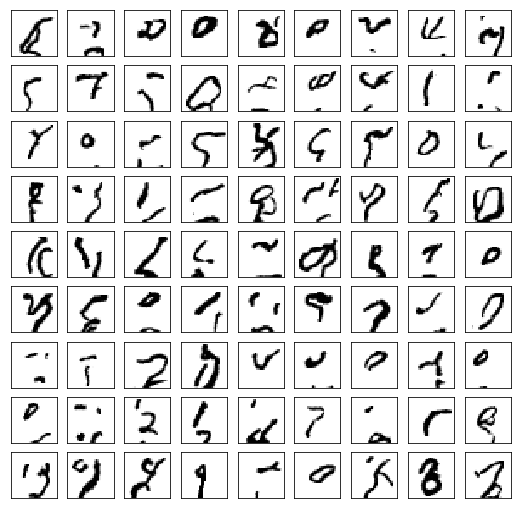

In [16]:
# Generating new images
samples = (np.random.rand(100, 28, 28, 1) * 0.01).astype('float32')
for i in range(28):
    for j in range(28):
        A = pixelcnn(samples)
        A = tf.reshape(A, [-1, 28, 28, q_levels, n_channel])
        A = tf.transpose(A, perm=[0, 1, 2, 4, 3])
        B = tf.nn.softmax(A)
        next_sample = B[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)

fig = plt.figure(figsize=(10,10))
for x in range(1, 10):
    for y in range(1, 10):
        ax = fig.add_subplot(10, 10, 10 * y + x)
        ax.matshow(samples[10 * y + x, :, :, 0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.show()

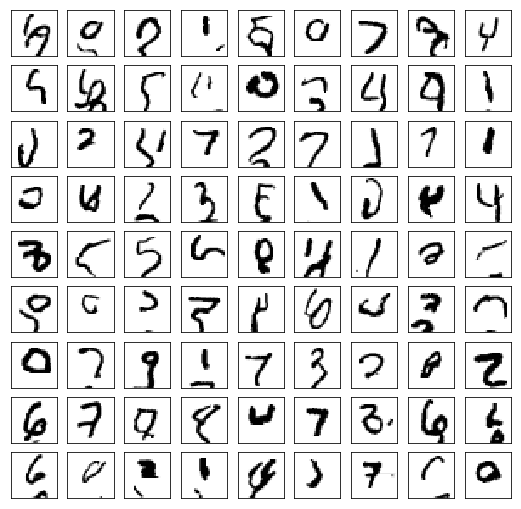

In [17]:
# Filling occluded images
occlude_start_row = 14
num_generated_images = 100
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, 28):
    for j in range(28):
        A = pixelcnn(samples)
        A = tf.reshape(A, [-1, 28, 28, q_levels, n_channel])
        A = tf.transpose(A, perm=[0, 1, 2, 4, 3])
        B = tf.nn.softmax(A)
        next_sample = B[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)

fig = plt.figure(figsize=(10,10))
for x in range(1, 10):
    for y in range(1, 10):
        ax = fig.add_subplot(10, 10, 10 * y + x)
        ax.matshow(samples[10 * y + x, :, :, 0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.show()